In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# list to store coordinates
coordinates = []

def get_coordinates(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # 
        print(f"Coordinate: ({x}, {y})")
        coordinates.append((x, y))
        if len(coordinates) == 3:  
            cv2.destroyAllWindows()

# Load the video
video_path = 'mouse_video.mp4'
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()

if ret:
    cv2.imshow("Click to mark lane entrances", frame)
    cv2.setMouseCallback("Click to mark lane entrances", get_coordinates)

    while len(coordinates) < 3:
        cv2.imshow("Click to mark lane entrances", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


cap.release()
cv2.destroyAllWindows()


print("Coordinates of the lane entrances:", coordinates)


Coordinate: (206, 466)
Coordinate: (278, 440)
Coordinate: (270, 513)
Coordinates of the lane entrances: [(206, 466), (278, 440), (270, 513)]


In [6]:
lane_1_coords = coordinates[0]
lane_2_coords = coordinates[1]
lane_3_coords = coordinates[2]


box_size = 45  

# Load the video
video_path = 'mouse_video.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties (frame width, height, FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# use 'XVID' for better compatibility
output_path = 'mouse_video_with_boxes.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Loop through the frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  

# Draw boxes around each lane entrance using manually adjusted sizes
    cv2.rectangle(frame, (lane_1_coords[0] - box_size // 2, lane_1_coords[1] - box_size // 2),
                         (lane_1_coords[0] + box_size // 2, lane_1_coords[1] + box_size // 2), (0, 255, 0), 2)
    
    cv2.rectangle(frame, (lane_2_coords[0] - box_size // 2, lane_2_coords[1] - box_size // 2),
                         (lane_2_coords[0] + box_size // 2, lane_2_coords[1] + box_size // 2), (0, 255, 0), 2)
    
    cv2.rectangle(frame, (lane_3_coords[0] - box_size // 2, lane_3_coords[1] - box_size // 2),
                         (lane_3_coords[0] + box_size // 2, lane_3_coords[1] + box_size // 2), (0, 255, 0), 2)

    out.write(frame)

# Release the resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Video saved as {output_path}")


Video saved as mouse_video_with_boxes.mp4


FPS: 29.0
Total video duration: 445.9655172413793 seconds
Final time point: 445.9310344827586 seconds


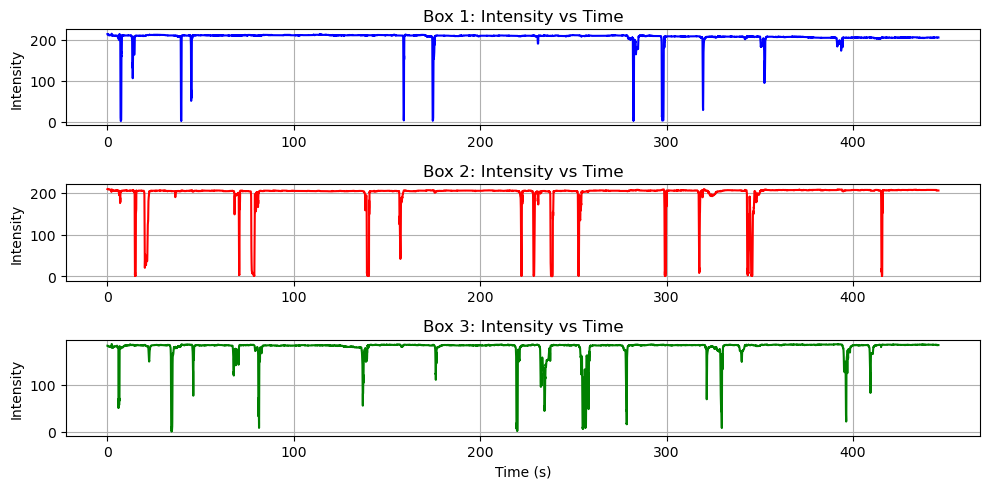

In [7]:
# Load video
video_path = 'mouse_video_with_boxes.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")


# Retrieve FPS and total number of frames
fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    print("Warning: FPS is 0, check the video file or camera.")
else:
    print("FPS:", fps)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate the duration of the video
duration = total_frames / fps
print(f"Total video duration: {duration} seconds")


point1 = coordinates[0]
point2 = coordinates[1]
point3 = coordinates[2]
region_size = int(np.sqrt(box_size))

# Lists for intensity values and time
intensity_box1 = []
intensity_box2 = []
intensity_box3 = []
time = []

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    x1, y1 = point1
    roi1 = gray_frame[y1-region_size//2:y1+region_size//2+1, x1-region_size//2:x1+region_size//2+1]
    
    x2, y2 = point2
    roi2 = gray_frame[y2-region_size//2:y2+region_size//2+1, x2-region_size//2:x2+region_size//2+1]
    
    x3, y3 = point3
    roi3 = gray_frame[y3-region_size//2:y3+region_size//2+1, x3-region_size//2:x3+region_size//2+1]

    intensity_box1.append(np.mean(roi1))
    intensity_box2.append(np.mean(roi2))
    intensity_box3.append(np.mean(roi3))
    
    # Calculate time for each frame
    time.append(frame_count / fps)
    frame_count += 1

# Release video capture object
cap.release()

# Verify the final time point
print(f"Final time point: {time[-1]} seconds")

# Plotting the intensity vs time for each box in separate subplots Before Denoising
fig, axs = plt.subplots(3, 1, figsize=(10, 5))


axs[0].plot(time, intensity_box1, label="Box 1", color="blue")
axs[0].set_ylabel('Intensity')
axs[0].set_title('Box 1: Intensity vs Time')
axs[0].grid(True)


axs[1].plot(time, intensity_box2, label="Box 2", color="red")
axs[1].set_ylabel('Intensity')
axs[1].set_title('Box 2: Intensity vs Time')
axs[1].grid(True)


axs[2].plot(time, intensity_box3, label="Box 3", color="green")
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Intensity')
axs[2].set_title('Box 3: Intensity vs Time')
axs[2].grid(True)

plt.tight_layout()
plt.show()

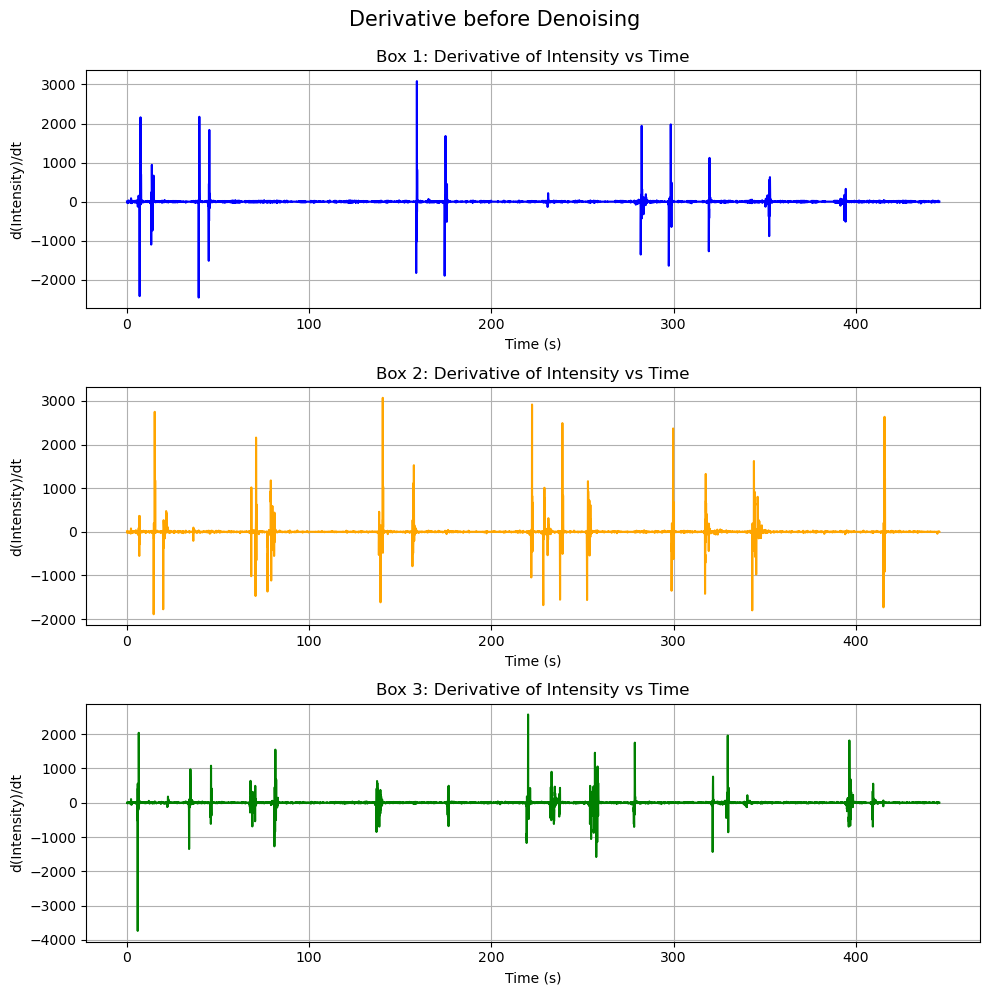

In [28]:
# Calculate derivative (rate of change of intensity)
dt = np.diff(time)  # Time intervals
dI_box1 = np.diff(intensity_box1) / dt  
dI_box2 = np.diff(intensity_box2) / dt  
dI_box3 = np.diff(intensity_box3) / dt  

# Plotting the derivative of intensity vs time for each box in separate subplots
fig, axs = plt.subplots(3, 1, figsize=(10,10))

# Box 1 Derivative
axs[0].plot(time[:-1], dI_box1, label="Box 1 Derivative", color="blue")
axs[0].set_ylabel('d(Intensity)/dt')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Box 1: Derivative of Intensity vs Time')
axs[0].grid(True)

# Box 2 Derivative
axs[1].plot(time[:-1], dI_box2, label="Box 2 Derivative", color="orange")
axs[1].set_ylabel('d(Intensity)/dt')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Box 2: Derivative of Intensity vs Time')
axs[1].grid(True)

# Box 3 Derivative
axs[2].plot(time[:-1], dI_box3, label="Box 3 Derivative", color="green")
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('d(Intensity)/dt')
axs[2].set_title('Box 3: Derivative of Intensity vs Time')
axs[2].grid(True)

# Adjust layout and show the plot
fig.suptitle("Derivative before Denoising",fontsize=15, y=0.99)
plt.tight_layout()
plt.show()

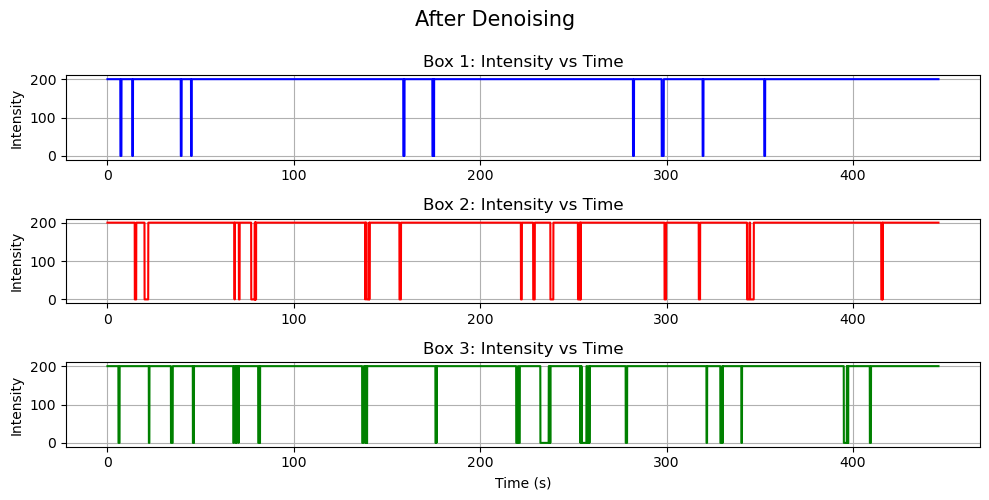

In [24]:
# After Denoising

set_threshold = 160
set_value_for_plot = 200

def denoising(sample,threshold=set_threshold, set_value=set_value_for_plot):
    denoised_vals = []
    for x in sample:
        if round(x)>=threshold:
            denoised_vals.append(set_value)
        else:
            denoised_vals.append(0)   
    
    return denoised_vals      


fig, axs = plt.subplots(3, 1, figsize=(10, 5))


axs[0].plot(time, denoising(intensity_box1), label="Box 1", color="blue")
axs[0].set_ylabel('Intensity')
axs[0].set_title('Box 1: Intensity vs Time')
axs[0].grid(True)


axs[1].plot(time, denoising(intensity_box2), label="Box 2", color="red")
axs[1].set_ylabel('Intensity')
axs[1].set_title('Box 2: Intensity vs Time')
axs[1].grid(True)


axs[2].plot(time, denoising(intensity_box3), label="Box 3", color="green")
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Intensity')
axs[2].set_title('Box 3: Intensity vs Time')
axs[2].grid(True)

fig.suptitle("After Denoising",fontsize=15, y=0.99)

# Adjust spacing between subplots
plt.tight_layout()

# Show plot
plt.show()

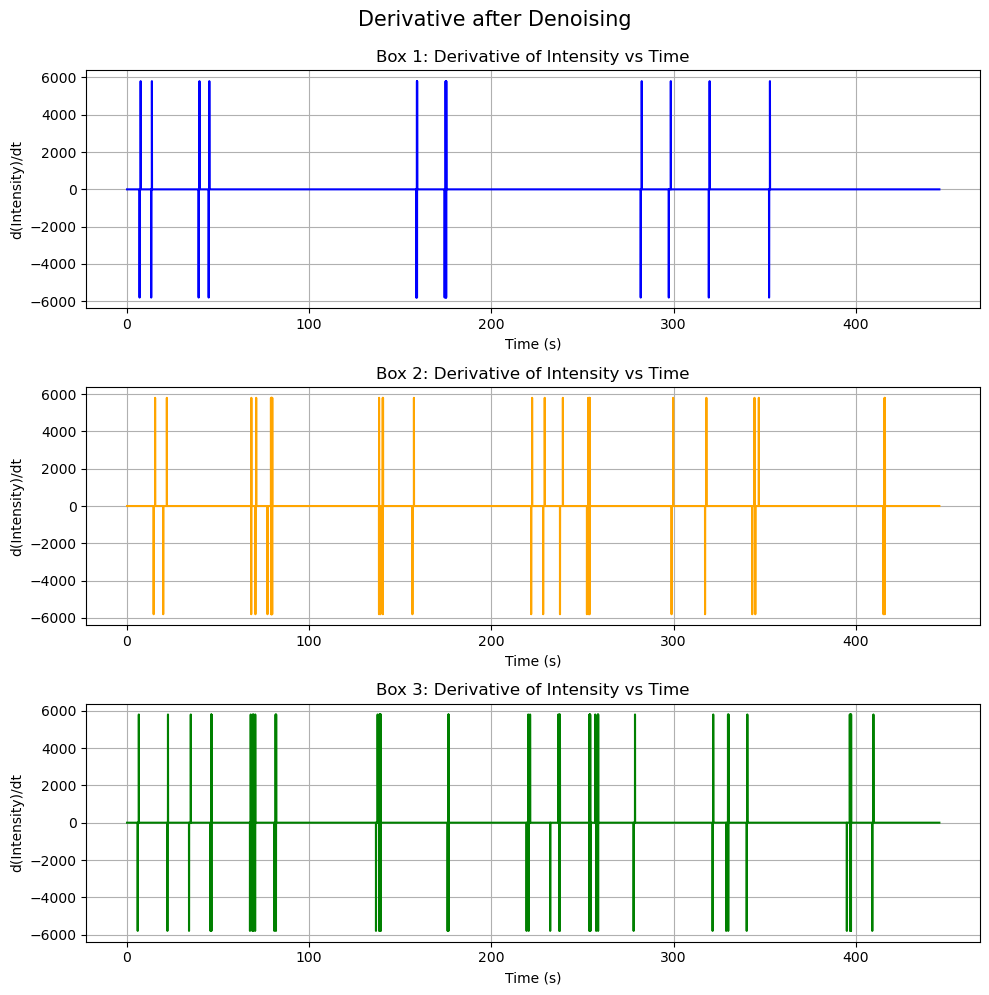

In [29]:
# Calculate derivative (rate of change of intensity) after Denoising
dt = np.diff(time)  # Time intervals
dI_box1 = np.diff(denoising(intensity_box1)) / dt  
dI_box2 = np.diff(denoising(intensity_box2)) / dt  
dI_box3 = np.diff(denoising(intensity_box3)) / dt  

# Plotting the derivative of intensity vs time for each box in separate subplots
fig, axs = plt.subplots(3, 1, figsize=(10,10))

# Box 1 Derivative
axs[0].plot(time[:-1], dI_box1, label="Box 1 Derivative", color="blue")
axs[0].set_ylabel('d(Intensity)/dt')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Box 1: Derivative of Intensity vs Time')
axs[0].grid(True)

# Box 2 Derivative
axs[1].plot(time[:-1], dI_box2, label="Box 2 Derivative", color="orange")
axs[1].set_ylabel('d(Intensity)/dt')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Box 2: Derivative of Intensity vs Time')
axs[1].grid(True)

# Box 3 Derivative
axs[2].plot(time[:-1], dI_box3, label="Box 3 Derivative", color="green")
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('d(Intensity)/dt')
axs[2].set_title('Box 3: Derivative of Intensity vs Time')
axs[2].grid(True)

# Adjust layout and show the plot
fig.suptitle("Derivative after Denoising",fontsize=15, y=0.99)
plt.tight_layout()
plt.show()

In [10]:
# Time points where change is observed in intensity

indices_box1 = np.where((dI_box1>0) | (dI_box1<0))[0]
time_val_box1 = np.array(time)[indices_box1]

indices_box2 = np.where((dI_box2>0) | (dI_box2<0))[0]
time_val_box2 = np.array(time)[indices_box1]

indices_box3 = np.where((dI_box3>0) | (dI_box3<0))[0]
time_val_box3 = np.array(time)[indices_box1]

In [11]:
print(f'Time points for 1st box:- {time_val_box1} \n')
print(f'Time points for 2st box:- {time_val_box2} \n')
print(f'Time points for 3st box:- {time_val_box3} \n')

Time points for 1st box:- [  6.89655172   7.48275862  13.27586207  13.65517241  39.31034483
  39.75862069  44.82758621  45.17241379 158.72413793 159.13793103
 159.17241379 159.24137931 174.34482759 174.89655172 175.03448276
 175.06896552 175.17241379 175.24137931 281.96551724 282.51724138
 297.37931034 298.48275862 319.34482759 319.79310345 352.4137931
 352.89655172] 

Time points for 2st box:- [  6.89655172   7.48275862  13.27586207  13.65517241  39.31034483
  39.75862069  44.82758621  45.17241379 158.72413793 159.13793103
 159.17241379 159.24137931 174.34482759 174.89655172 175.03448276
 175.06896552 175.17241379 175.24137931 281.96551724 282.51724138
 297.37931034 298.48275862 319.34482759 319.79310345 352.4137931
 352.89655172] 

Time points for 3st box:- [  6.89655172   7.48275862  13.27586207  13.65517241  39.31034483
  39.75862069  44.82758621  45.17241379 158.72413793 159.13793103
 159.17241379 159.24137931 174.34482759 174.89655172 175.03448276
 175.06896552 175.17241379 175.2